In [1]:
using Gurobi, JuMP, MLBase
using Statistics, Random, Distributions

In [2]:
gurobi_env = Gurobi.Env();

Academic license - for non-commercial use only - expires 2021-07-23


In [3]:
HH = 10
BB = 1
function objective_fun(d, z; step = 250)
    mark = floor((d + step - 1) / step) * step 
    
    if z < d 
        return d - z
    end 
    
    if z > mark 
        return d
    else 
        return 0
    end
    
    
#     if z < d 
#         return z
#     end 
    
#     if z > mark 
#         return 0
#     else 
#         return d
#     end

end

objective_fun (generic function with 1 method)

In [53]:
using CSV, DataFrames 

training = DataFrame(CSV.File("housing/train.csv", header = true));
testing  = DataFrame(CSV.File("housing/test.csv", header = true));

data = training[!, [:GarageArea, :OverallQual, :GrLivArea, :GarageCars, :LotArea, :SalePrice]];
data[!, :SalePrice] ./= 100 
data = data[shuffle(axes(data, 1)), :]

# k_folds = kfolds(data'; k = 10)

n_train = 1000
n_validate = 230
n_test = 230


X_train = convert(Matrix, data[1:n_train, [:GarageArea, :OverallQual, :GrLivArea, :GarageCars, :LotArea]])
X_validate = convert(Matrix, data[n_train+1:n_train+n_validate, [:GarageArea, :OverallQual, :GrLivArea, :GarageCars, :LotArea]])
X_test = convert(Matrix, data[n_train+n_validate+1:end , [:GarageArea, :OverallQual, :GrLivArea, :GarageCars, :LotArea]])

c_train =      (data[1:n_train, :SalePrice]) 
c_validate =   (data[n_train+1:n_train+n_validate, :SalePrice]) 
c_test = (data[n_train+n_validate+1:end, :SalePrice]);

In [54]:
function solve_kallus(weights) 
    model = Model(() -> Gurobi.Optimizer(gurobi_env))
    MOI.set(model, MOI.Silent(), true)

    @variable(model, z)
    @variable(model, s[1:n_train])
    @variable(model, q[1:n_train] >= 0)
    @variable(model, high[1:n_train], Bin)
    
    for i=1:n_train
        step = 250
        mark = floor((c_train[i] + step - 1) / step) * step 
        @constraint(model, z <= mark + 100000 * high[i])
        
        @constraint(model, q[i] >= c_train[i] - z)
        @constraint(model, q[i] >= c_train[i] * high[i])
    end;

    @objective(model, Min, sum(q .* weights))
    optimize!(model)
    return value.(z)
end

solve_kallus (generic function with 1 method)

In [55]:
using ScikitLearn
@sk_import tree: _tree
@sk_import tree: (DecisionTreeRegressor, DecisionTreeClassifier)

function train_test_bk(X_tr, c_tr, X_tes, c_tes; depth = 100, min_samples_leaf = 1)

    tree = DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf)
    tree.fit(X_tr, c_tr)

    bins = tree.apply(X_tr)
    tree_region = Dict()
    for i = 1:n_train 
        if haskey(tree_region, bins[i])
            cur = tree_region[bins[i]]  
            push!(cur, i)
        else
            cur = [i]
        end
        tree_region[bins[i]] = cur
    end 

    tree_prescription = Dict()
    for (key, vals) in tree_region
        weights = zeros(n_train)
        for v in vals 
            weights[v] = 1
        end

        tree_prescription[key] = solve_kallus(weights)
    end
    
    
    # test 
    
    tree_bk = Vector{Float64}()
    below_bk = Vector{Float64}()

    bk_profit = 0

    for i = 1:size(c_tes)[1]
        x = X_tes[i,:]
        true_cost = c_tes[i]

        leaf = tree.apply([x])[1]
        tree_obj = objective_fun(true_cost, tree_prescription[leaf])   

        bk_profit += tree_obj

        error = tree_obj / true_cost
        push!(tree_bk, error)
    end;

    for i in 1:size(c_tes)[1]
        if tree_bk[i] < 0.99
            push!(below_bk, tree_bk[i])
        end 
    end
    
    return mean(tree_bk), mean(below_bk), median(below_bk), size(below_bk)[1], tree_bk
end

train_test_bk (generic function with 1 method)

In [69]:
bk_all = Vector{Any}()
best = 10000
params = 0
for depth in 2:10
    for leaf in 1:10
        results = train_test_bk(X_train, c_train, X_test, c_test; depth = depth, min_samples_leaf = leaf)
        mean_val = results[1]
        push!(bk_all, results)
        if mean_val < best 
            best = mean_val 
            params = depth, leaf
        end
    end
end

In [70]:
println(best)
println(params)

0.19747046197111873
(6, 10)


In [59]:
results = train_test_bk(X_train, c_train, X_test, c_test; depth = params[1], min_samples_leaf = params[2])

(0.19899543721141275, 0.10131195394451184, 0.07407407407407407, 205, [1.0, 0.0245806, 0.107143, 0.117128, 0.100719, 0.30162, 0.25, 0.0666667, 0.015748, 0.0  …  0.00662252, 0.134615, 0.193548, 0.00841431, 0.100719, 0.0, 0.174917, 0.187784, 0.4, 0.0])

In [22]:
# Least Squares
include("./least_squares.jl")
import .LS

B = LS.train(X_train, c_train'; epochs=20, lr = 1e-3);

errors = LS.evaluate_newsvendor(X_test', c_test, B, objective_fun)
println("Error: ", mean(errors), " ", median(errors))

Epoch 10 LOSS: 6.404804448538946e172
Epoch 20 LOSS: Inf
LOSS: Inf


DimensionMismatch: DimensionMismatch("A has dimensions (1,1001) but B has dimensions (6,230)")

In [60]:
include("./local_housing.jl")
P = LocalHousing.ProblemNewsvendor(HH, BB, X_train, c_train);

Academic license - for non-commercial use only - expires 2021-07-23


In [61]:
include("./local_housing.jl")

function train_test_cap(X_train, c_train, X_test, c_test; EPS = 250, max_depth = 10, min_samples_leaf = 5)

    results = Vector{Any}()
    mine_below = Vector{Float64}()
    all_errors = Vector{Float64}()

    below_tree = Vector{Any}()
    below_mine = Vector{Any}()

    mine_below = Vector{Float64}()

    my_profit = 0


    println("EPS: ", EPS)
    LocalHousing.init_n(P, EPS)


    LocalHousing.init_models(P, DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf, class_weight="balanced"));    


    for i = 1:size(X_test)[1]
        x = X_test[i,:]
        true_demand = c_test[i]

        my_prescription = LocalHousing.predict(P, x; eps = -1)
        my_obj = objective_fun(true_demand, my_prescription)

        my_profit += my_obj
        error = my_obj / true_demand
        push!(all_errors, error)
    end;

    for i in 1:size(X_test)[1]
        if all_errors[i] < 0.99
            push!(mine_below, all_errors[i])
        end 
    end
    
    
    return mean(all_errors), median(all_errors), mean(mine_below), median(mine_below), size(mine_below), all_errors
end

Academic license - for non-commercial use only - expires 2021-07-23


train_test_cap (generic function with 1 method)

In [65]:
results = train_test_cap(X_train, c_train, X_validate, c_validate; EPS = 225, max_depth = 10, min_samples_leaf = 5)

EPS: 200


(0.179749315791672, 0.08031847708408517, 0.09733178292863427, 0.06832298136645963, (209,), [0.0228013, 0.0892532, 0.476987, 0.0876329, 0.23913, 0.0196078, 1.0, 0.0272374, 0.0, 0.047619  …  0.0, 0.166667, 0.303621, 0.0601504, 0.0, 0.186065, 0.0, 0.0, 0.1033, 0.130435])

In [68]:
results = train_test_cap(X_train, c_train, X_test, c_test; EPS = 250, max_depth = 10, min_samples_leaf = 5)

EPS: 250


(0.17450436841484, 0.07364500737994714, 0.10441511667647731, 0.05433795139677493, (212,), [1.0, 0.0245806, 0.0, 0.117128, 0.100719, 0.30162, 0.25, 0.0, 0.212598, 0.0  …  0.00662252, 0.326923, 0.193548, 0.00841431, 0.0, 0.0, 0.00990099, 0.187784, 0.466667, 0.0])

In [ ]:
results[1] 

In [ ]:
Use EPS = 0 in LP 

EPS: 25
25 215 0.03508771929824561 0.0944835947561957
EPS: 50
50 216 0.04671028716830243 0.09364930805355912
EPS: 75
75 218 0.03391290726817042 0.09163806623351754
EPS: 100
100 217 0.037721324095458045 0.09355627603440718
EPS: 125
125 220 0.04397356029364453 0.09552601640076941
EPS: 150
150 220 0.042374855336014774 0.09138149085465119
EPS: 175
175 216 0.03640452169685183 0.09160122754540144
EPS: 200
200 213 0.03508771929824561 0.08976853604119592
EPS: 225
225 214 0.042131532589547854 0.09240162788976462
EPS: 250
250 217 0.031007751937984496 0.0895342023282809
EPS: 275
275 217 0.030470914127423823 0.08898220888190148
EPS: 300
300 210 0.03073933303270416 0.0889059187980779
EPS: 325
325 217 0.030470914127423823 0.08890590337015916
EPS: 350
350 209 0.0249609984399376 0.08876343926195543
EPS: 375
375 213 0.015748031496062992 0.08539810212916651
EPS: 400
400 207 0.030470914127423823 0.08354901793228751
EPS: 425
425 209 0.030470914127423823 0.08227661857067715
EPS: 450
450 205 0.027777777777777776 0.0809451971688835
EPS: 475
475 209 0.01429275505174963 0.07888753902604226
EPS: 500
500 210 0.012751786874593891 0.08034519430138894


In [ ]:
EPS: 25
25 211 0.038461538461538464 0.09453789293065921
EPS: 50
50 221 0.05362776025236593 0.0948528923555876
EPS: 75
75 221 0.038461538461538464 0.09466288923119862
EPS: 100
100 224 0.04397356029364453 0.09488618547525271
EPS: 125
125 222 0.05339195321588396 0.09740361209100756
EPS: 150
150 230 0.053840907153209994 0.09531210827542216
EPS: 175
175 229 0.05405405405405406 0.09687700128499771
EPS: 200
200 228 0.04397356029364453 0.09268258973427962
EPS: 225
225 226 0.05503206163999116 0.09668780806099117
EPS: 250
250 225 0.06103286384976526 0.09978306326732776
EPS: 275
275 226 0.05503206163999116 0.09704482059965562
EPS: 300
300 230 0.038091431278498254 0.09307748545022565
EPS: 325
325 230 0.05255933530839883 0.09733365087294298
EPS: 350
350 229 0.05405405405405406 0.09872231401852952


In [119]:
include("./local_housing.jl")

using ScikitLearn
@sk_import tree: DecisionTreeClassifier
@sk_import neural_network: MLPClassifier

EPS = 225
LocalHousing.init_n(P, EPS)

# LocalNewsvendor.init_models(P, MLPClassifier(solver="lbfgs", alpha=1e-5, hidden_layer_sizes=(30), random_state=1));
LocalHousing.init_models(P, DecisionTreeClassifier(class_weight="balanced"));

Academic license - for non-commercial use only - expires 2021-07-23


In [120]:
using ScikitLearn
@sk_import neighbors: KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=15)
neigh.fit(X_train, c_train)

PyObject KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='uniform')

In [121]:
function knn(P, x)
    return neigh.predict([x])[1]
end

knn (generic function with 1 method)

In [64]:
include("./local_housing.jl")
include("./DT.jl")

@sk_import ensemble: RandomForestRegressor
@sk_import linear_model: LinearRegression

import .LocalNewsvendor
import .DecisionTree_

bk_all = Vector{Any}()
best = 10000
params = 0
for depth in 2:2
    for leaf in 1:1

#         tree = RandomForestRegressor(max_depth = depth, min_samples_leaf = leaf)
#         tree = DecisionTree_.train_tree_(X_train, c_train .* 1; depth = depth, min_samples_leaf = leaf)
        tree = LinearRegression()
        
        tree.fit(X_train, c_train)

        nn_errors = Vector{Float64}()

        for i = 1:size(X_test)[1]
            x = X_test[i,:]
            true_demand = c_test[i]

            nn_presc = tree.predict([x])[1]
            nn_obj = objective_fun(true_demand, nn_presc)

            error = nn_obj / true_demand

            push!(nn_errors, error)
        end;

        mean_val = mean(nn_errors)
        if mean_val < best 
            best = mean_val 
            params = depth, leaf
        end
        
        println(params)
        println(mean_val)
        println()
    end
end



Academic license - for non-commercial use only - expires 2021-07-23
(2, 1)
0.3780306293590392



In [55]:
below_mine = Vector{Float64}()
below_other = Vector{Float64}()

for i in 1:n_test
    if all_errors[i] < 0.99
        push!(below_mine, all_errors[i])
    end 
    if nn_errors[i] < 0.99 
        push!(below_other, nn_errors[i])
    end
end

println("Mine : ", size(below_mine)[1], " ", median(below_mine), " ", mean(below_mine))
println("Other: ", size(below_other)[1], " ", median(below_other), " ", mean(below_other))

UndefVarError: UndefVarError: all_errors not defined

In [ ]:
Mine : 228 0.05660377358490566 0.09559724144103378
Other: 170 0.08253733136136929 0.10656725081278598


In [14]:
# println("Cap: ", adam_loss / optimum * 100)
# println("NN : ", nn_adam_loss / optimum * 100)

println("CAP: ", median(all_errors), " ", mean(all_errors), " ", std(all_errors))
println("NN : ", median(nn_errors), " ", mean(nn_errors), " ", std(nn_errors))

saa = mean(c_train)
println("SAA: ", mean([objective_fun(d, saa) for d in c_test]))

CAP: 0.05532891381947986 0.22003161895340922 0.346426298360829
NN : 0.11887107514485937 0.374359429606559 0.4376094272127888
SAA: 1043.1157707692307


In [33]:
println("OPT: ", mean([objective_fun([c_test[i]], (1 / sqrt(p_features)) * B_true * X_test[:,i] .+ 4) for i=1:n_test]))

OPT: [34.0467]


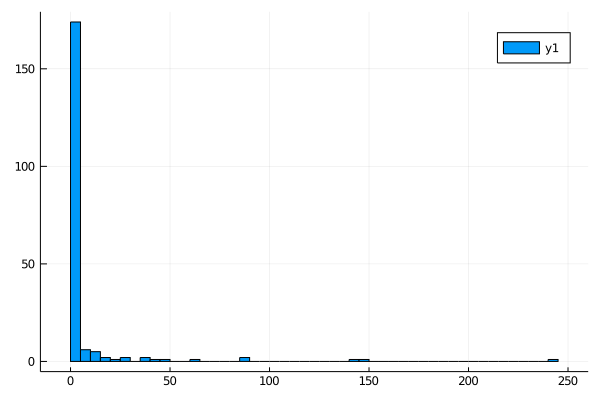

In [31]:
using Plots

Plots.histogram(all_errors, bins=100)

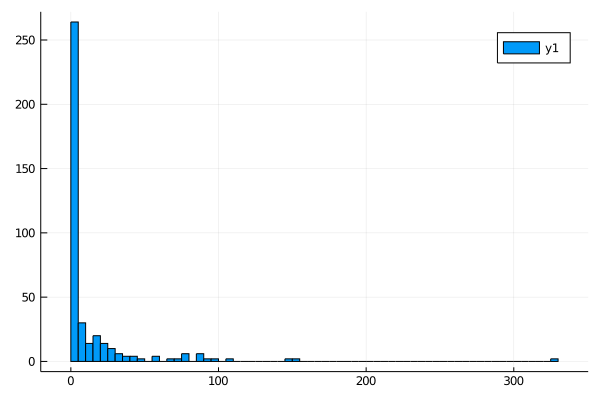

In [32]:
Plots.histogram(nn_all_errors, bins=100)